In [3]:
import os
import json
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from visualizations.solution_visualization import plot_gantt_chart, plot_robot_trajectories
from helper_functions.schedules import Full_Horizon_Schedule


### Dataset of exact solutions of Full_Horizon_Schedules

In [4]:
def load_dataset(problem_dir, solution_dir):
    problems = []
    solutions = []
    
    # Load all problem instances
    for file_name in sorted(os.listdir(problem_dir)):
        with open(os.path.join(problem_dir, file_name), "r") as f:
            problems.append(json.load(f))
    
    # Load all solution files
    for file_name in sorted(os.listdir(solution_dir)):
        with open(os.path.join(solution_dir, file_name), "r") as f:
            solutions.append(json.load(f))
    
    solutions = [Full_Horizon_Schedule.from_dict(solution) for solution in solutions]
    
    return problems, solutions

In [5]:
# Define paths
problem_dir = "/home/jakob/thesis/datasets/simple_dataset_1000/problem_instances"
solution_dir = "/home/jakob/thesis/datasets/simple_dataset_1000/solutions"

# Load dataset
problems, solutions = load_dataset(problem_dir, solution_dir)

IntSlider(value=319, continuous_update=False, description='Solution:', max=999)

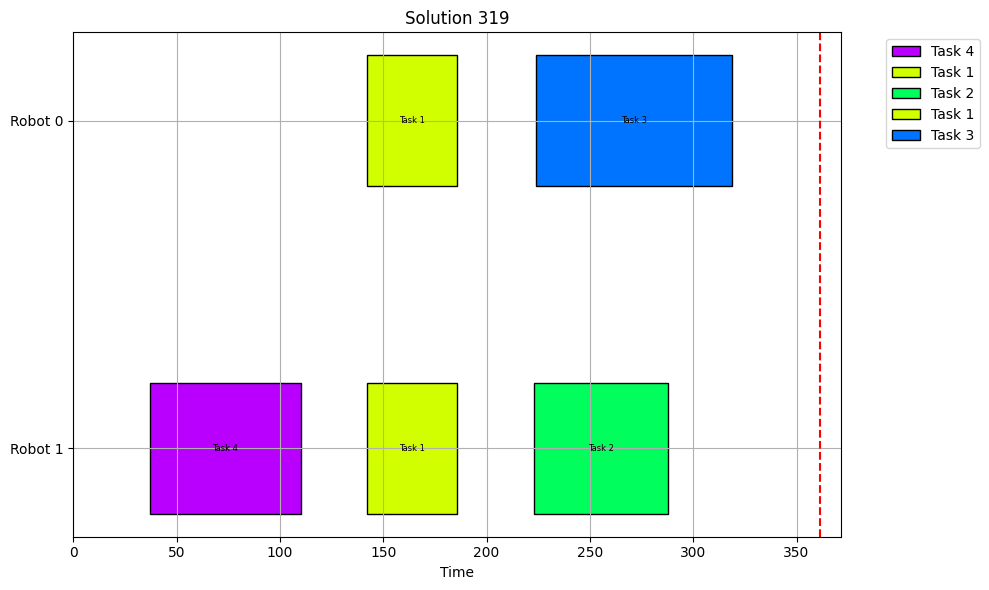

In [6]:
def update_plot(change):
    """Update the Gantt chart when the slider value changes."""
    index = slider.value  # Get the current slider value
    solution = solutions[index]
    clear_output(wait=True)  # Clear previous output
    display(slider)  # Re-display the slider
    plot_gantt_chart(f"Solution {index}", solution)  # Plot the updated Gantt chart

# Create the slider
slider = widgets.IntSlider(
    value=0,  # Default starting index
    min=0,    # Minimum index
    max=len(solutions) - 1,  # Maximum index based on solutions size
    step=1,   # Step size for the slider
    description='Solution:',
    continuous_update=False  # Update only when the slider is released
idle_robotsidle_robots)

# Attach the update function to the slider's change event
slider.observe(update_plot, names='value')

update_plot(None)  # Display the initial plot


### Initial Transformer only approach
Transformer on robots + tasks --> reward matrix, Bipartite Graph Matching --> Instantaneous schedule --> Roll out in simulator


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SingleHeadTransformerBlock(nn.Module):
    def __init__(self, embed_dim, ff_dim, dropout=0.0):
        """
        Initializes a Transformer Block with a single-head attention mechanism.

        Args:
            embed_dim (int): Size of input embeddings.
            ff_dim (int): Size of the feed-forward layer.
            dropout (float): Dropout rate.
        """
        super(SingleHeadTransformerBlock, self).__init__()
        self.embed_dim = embed_dim

        # Linear layers for Q, K, V
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)

        # Output projection after attention
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

        # Layer normalizations
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def attention(self, Q, K, V, mask=None):
        """
        Compute the scaled dot-product attention.

        Args:
            Q (torch.Tensor): Query tensor of shape (batch_size, seq_len, embed_dim).
            K (torch.Tensor): Key tensor of shape (batch_size, seq_len, embed_dim).
            V (torch.Tensor): Value tensor of shape (batch_size, seq_len, embed_dim).
            mask (torch.Tensor, optional): Attention mask of shape (batch_size, seq_len, seq_len).

        Returns:
            torch.Tensor: Attention output of shape (batch_size, seq_len, embed_dim).
        """
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.embed_dim ** 0.5)  # (batch_size, seq_len, seq_len)

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, seq_len, seq_len)

        return torch.matmul(attention_weights, V)  # (batch_size, seq_len, embed_dim)


    def forward(self, x, mask=None):
        """
        Forward pass of the Transformer Block.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, embed_dim).
            mask (torch.Tensor, optional): Attention mask of shape (batch_size, seq_len, seq_len).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, embed_dim).
        """
        # Attention
        Q = self.query_proj(x)  # (batch_size, seq_len, embed_dim)
        K = self.key_proj(x)    # (batch_size, seq_len, embed_dim)
        V = self.value_proj(x)  # (batch_size, seq_len, embed_dim)

        attention_output = self.attention(Q, K, V, mask)  # (batch_size, seq_len, embed_dim)
        attention_output = self.out_proj(attention_output)

        x = x + self.dropout(attention_output)
        x = self.norm1(x)

        # Feed-forward
        ffn_output = self.ffn(x)
        x = x + self.dropout(ffn_output)
        x = self.norm2(x)

        return x



In [8]:
class TransformerScheduler(nn.Module):
    def __init__(self, robot_input_dimensions, task_input_dimension, embed_dim, ff_dim, num_layers, dropout = 0.0):
        
        super(TransformerScheduler, self).__init__()
        self.robot_embedding = nn.Linear(robot_input_dimensions, embed_dim)
        self.task_embedding = nn.Linear(task_input_dimension, embed_dim)

        self.transformer_blocks = nn.ModuleList([
            SingleHeadTransformerBlock(embed_dim, ff_dim, dropout) for _ in range(num_layers)
        ])

    def forward(self, robot_features, task_features):
        robot_embeddings = self.robot_embedding(robot_features)
        task_embeddings = self.task_embedding(task_features)

        x = torch.cat([robot_embeddings, task_embeddings], dim=1)

        for transformer in self.transformer_blocks:
            x = transformer(x)

        n_robots = robot_features.shape[1] 

        features_per_robot = x[:, :n_robots]
        features_per_task = x[:, n_robots:]
        reward_matrix = torch.matmul(features_per_robot, features_per_task.transpose(1,2))
        
        return reward_matrix 

In [32]:
class Robot:
    def __init__(self, capabilities):
        self.capability = np.array(capabilities)  
        self.available = 1  # 0 if not available, 1 if available

    def feature_vector(self):
        return np.concatenate([self.capability, np.array([self.available])])


class Task:
    def __init__(self, skills_required):
        self.skills_required = np.array(skills_required)  
        self.ready = 1 # 0 if not ready, 1 if ready --> predecessor tasks are finished
        self.assigned = 0 # 0 if not assigned, 1 if assigned
        self.incomplete = 1 # 0 if completed, 1 if incomplete  

    def feature_vector(self):
        return np.concatenate([self.skills_required, np.array([self.ready, self.assigned, self.incomplete])])

In [33]:
n_robots = 2
n_tasks = 3
n_skills = 2 


In [40]:
robots = [Robot([1, 0]), Robot([0, 1])]
tasks = [Task([1, 0]), Task([0, 1]), Task([1, 1])]

robot_features = np.stack([robot.feature_vector() for robot in robots])
robot_features = torch.tensor(robot_features).unsqueeze(0).float()

task_features = np.stack([task.feature_vector() for task in tasks])
task_features = torch.tensor(task_features).unsqueeze(0).float()


print(robot_features)
print(task_features)

tensor([[[1., 0., 1.],
         [0., 1., 1.]]])
tensor([[[1., 0., 1., 0., 1.],
         [0., 1., 1., 0., 1.],
         [1., 1., 1., 0., 1.]]])


In [38]:
# Example input
batch_size = 1 
seq_len = n_robots + n_tasks

scheduling_network = TransformerScheduler(robot_input_dimensions=3, task_input_dimension=5, embed_dim=32, ff_dim=64, num_layers=2)

In [39]:
reward_matrix = scheduling_network(robot_features, task_features)

In [ ]:
import pulp

def solve_bipartite_matching(R, a_r, s_t, c_r, w_r, c_t, w_t):
    """
    R    : 2D list or np.array, shape [n_robots, M], reward matrix
    a_r  : list of size n_robots, robot availability (1=available, 0=unavailable)
    s_t  : list of size M, task readiness (1=ready, 0=not ready); index M is idle task
    c_r  : list of lists, c_r[i] is the capability vector of robot i
    w_r  : list, w_r[i] is the payload capacity of robot i
    c_t  : list of lists, c_t[j] is the capability vector required by task j
    Returns: dict of {(i, j): 0/1} solutions indicating the best A_{i,j}.
    """

    n_robots = len(R)     
    n_tasks = len(R[0]) 
    n_tasks  = len(c_r[0])    

    problem = pulp.LpProblem("BipartiteMatching", pulp.LpMaximize)

    # Decision variables: A[i][j] in {0,1}
    A = pulp.LpVariable.dicts("A", (range(n_robots), range(n_tasks)),
                              lowBound=0, upBound=1, cat=pulp.LpBinary)

    # Objective: maximize sum_i sum_j A[i,j] * R[i,j]
    problem += pulp.lpSum(R[i][j] * A[i][j]
                          for i in range(n_robots)
                          for j in range(n_tasks)), "TotalReward"

    # Constraint: each robot can take at most one task
    for robot in range(n_robots):
        problem += pulp.lpSum(A[robot][task] for task in range(n_tasks)) <= a_r[i]

    # Subteaming constraints for real tasks (j < M):
    for task in range(n_tasks - 1):
        # Only constrain if this task is ready
        if s_t[task] == 1:
            # 1) Capability requirement: if c_t[j][p] = 1, subteam must have it
            for cap in range(n_tasks):
                if c_t[task][cap] == 1:
                    problem += pulp.lpSum(c_r[robot][cap] * A[robot][task] for robot in range(n_robots)) >= 1

        else:
            # If task j is not ready, force no assignment
            for robot in range(n_robots):
                problem += A[robot][task] == 0

    problem.solve(pulp.PULP_CBC_CMD(msg=0))
    solution = {(robot, task): int(pulp.value(A[robot][task])) for robot in range(n_robots) for task in range(n_tasks)}

    return solution


R    = [[4, 10, 0],   # Rewards for 2 robots, 2 tasks + 1 idle
        [1, 5, 0]]
a_r  = [1, 1]        # Both robots are available
s_t  = [1, 1]        # Two tasks are ready; index=2 is idle
c_r  = [[1, 1], [1, 1]]  # Robot0 has (manipulation=1, mobility=1), Robot1 has (1, 0)
w_r  = [20, 10]      # Payload capacities
c_t  = [[1, 1], [1, 0]]  # Task0 requires (1,1), Task1 requires (1,0)
w_t  = [10, 10]      # Payload requirements

solution = solve_bipartite_matching(R, a_r, s_t, c_r, w_r, c_t, w_t)
print("Optimal schedule matrix A:")
for (i, j), val in solution.items():
    if val == 1:
        print(f"  Robot {i} assigned to task {j}")


Optimal schedule matrix A:
  Robot 0 assigned to task 1
  Robot 1 assigned to task 0
